In [1]:
# Notebook to explore more serious convolutional networks 
# i.e. includes analysis of training and test accuracies

In [2]:
# Tried a few things:
# More convolution layers did not increase accuracy
# BatchNorm helps the training initialy

(1, 2, 1)
Normalizing dataset from [3.06895569 2.89975535] to
[1. 1.]
Normalizing dataset from [3.07249511 2.90168533] to
[1.0011533  1.00066557]
Normalizing dataset from [3.0693023  2.88299791] to
[1.00011294 0.99422108]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7497, 2, 32)
Labels shape:  (7497,)
Unique labels:  [0 1 2]
Shape of test set: (1125, 2, 32)
Shape of train set: (5416, 2, 32)
Shape of validation set: (956, 2, 32)
Fraction of single class in test set:  0.31377777777777777
dtype of inputs:  torch.float32


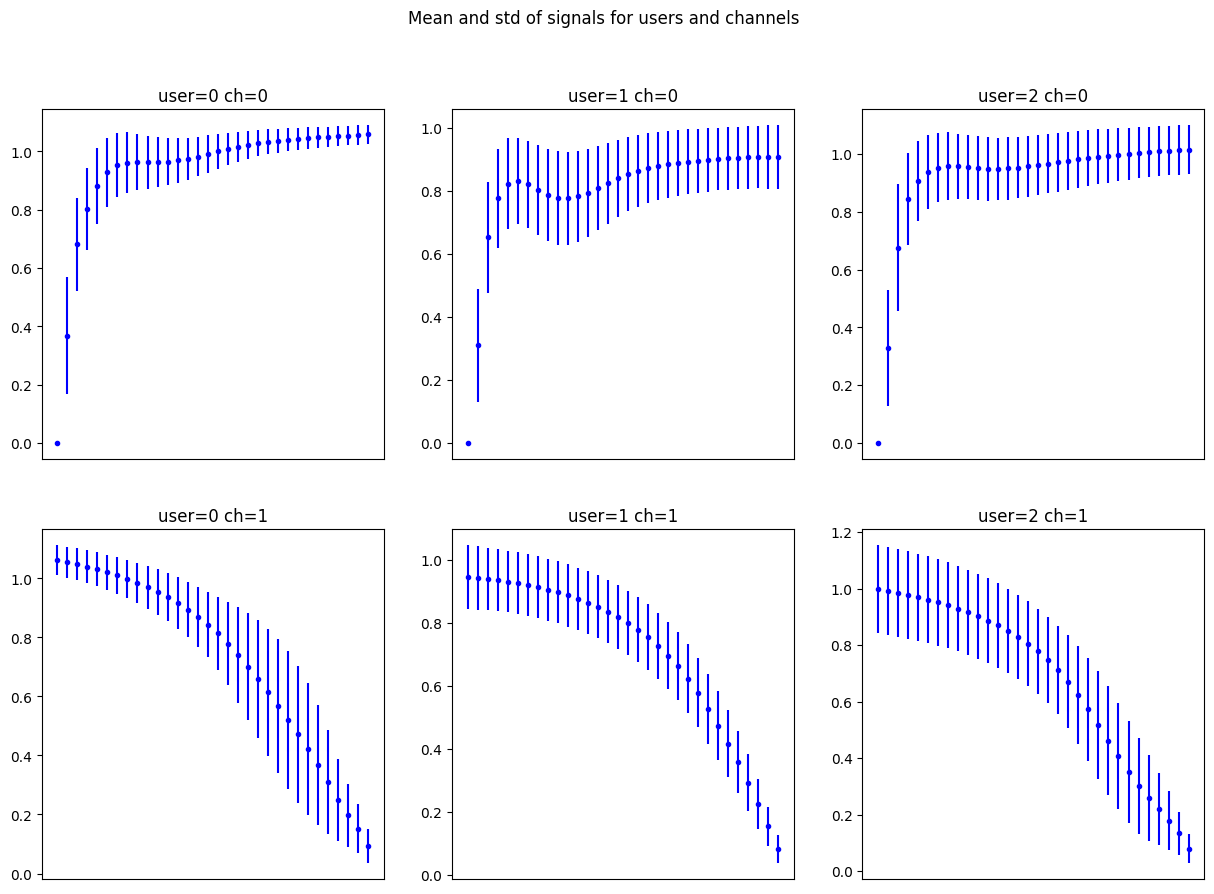

In [1]:
from core_functions import SensorSignals
from networks import CNN_Simple, CNN_Dense
dataPath = "./second_collection_triggs_rels_32.npz"
S = SensorSignals(dataPath, triggers=True, releases=True) 
S.split_data()
S.norm_X()
S.setup_tensors()
S.print_shapes()
S.plot_data()

In [2]:
models = [CNN_Simple(input_ch=2, n_filters=8)]
S.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*256, max_epochs=50)

Epoch 1, Batch 1: loss_tr=1.475, loss_val=6.752, train=30.2%, val=28.1%
Epoch 2, Batch 1: loss_tr=0.698, loss_val=1.116, train=42.8%, val=42.2%
Epoch 3, Batch 1: loss_tr=0.540, loss_val=0.593, train=72.1%, val=74.2%
Epoch 4, Batch 1: loss_tr=0.507, loss_val=0.586, train=74.0%, val=74.8%
Epoch 5, Batch 1: loss_tr=0.449, loss_val=0.732, train=70.9%, val=69.1%
Epoch 6, Batch 1: loss_tr=0.383, loss_val=0.496, train=78.3%, val=77.6%
Epoch 7, Batch 1: loss_tr=0.349, loss_val=0.447, train=81.5%, val=81.3%
Epoch 8, Batch 1: loss_tr=0.358, loss_val=0.358, train=85.4%, val=86.3%
Epoch 9, Batch 1: loss_tr=0.328, loss_val=0.333, train=85.6%, val=86.8%
Epoch 10, Batch 1: loss_tr=0.293, loss_val=0.349, train=85.5%, val=84.7%
Epoch 11, Batch 1: loss_tr=0.296, loss_val=0.284, train=87.9%, val=89.2%
Epoch 12, Batch 1: loss_tr=0.311, loss_val=0.336, train=86.1%, val=86.7%
Epoch 13, Batch 1: loss_tr=0.290, loss_val=0.279, train=88.9%, val=88.8%
Epoch 14, Batch 1: loss_tr=0.244, loss_val=0.321, train=87.1

Test accuracy of lowest val acc=91.5: 91.0%


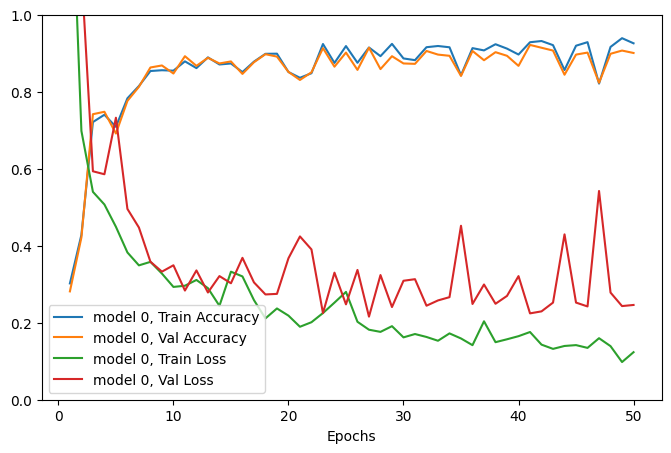

In [3]:
S.plot_train()
S.bestModelAcc()

In [1]:
# Look at using several signals, one per channel
from core_functions import SensorSignals
from networks import CNN_Simple, CNN_Dense
D = SensorSignals("./second_collection_triggs_rels_32.npz", triggers=True, releases=True) 
D.split_data()
D.norm_X()
D.resample_random_combinations()
D.setup_tensors()
D.print_shapes()
# D.plot_data()

(1, 2, 1)
Normalizing dataset from [3.06895569 2.89975535] to
[1. 1.]
Normalizing dataset from [3.07249511 2.90168533] to
[1.0011533  1.00066557]
Normalizing dataset from [3.0693023  2.88299791] to
[1.00011294 0.99422108]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7497, 2, 32)
Labels shape:  (7497,)
Unique labels:  [0 1 2]
Shape of test set: (5625, 6, 32)
Shape of train set: (27080, 6, 32)
Shape of validation set: (4780, 6, 32)
Fraction of single class in test set:  0.31377777777777777
dtype of inputs:  torch.float32


In [2]:
models = [CNN_Simple(input_ch=6, n_filters=16)]
D.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=10*256, max_epochs=30)

Epoch 1, Batch 1: loss_tr=1.216, loss_val=4.356, train=57.3%, val=58.3%
Epoch 2, Batch 1: loss_tr=0.595, loss_val=0.546, train=66.9%, val=68.6%
Epoch 3, Batch 1: loss_tr=0.342, loss_val=0.329, train=84.5%, val=85.4%
Epoch 4, Batch 1: loss_tr=0.236, loss_val=0.206, train=90.3%, val=93.4%
Epoch 5, Batch 1: loss_tr=0.188, loss_val=0.151, train=93.5%, val=95.3%
Epoch 6, Batch 1: loss_tr=0.148, loss_val=0.131, train=94.2%, val=95.2%
Epoch 7, Batch 1: loss_tr=0.139, loss_val=0.103, train=95.4%, val=96.5%
Epoch 8, Batch 1: loss_tr=0.105, loss_val=0.101, train=95.7%, val=96.5%
Epoch 9, Batch 1: loss_tr=0.086, loss_val=0.090, train=96.5%, val=97.0%
Epoch 10, Batch 1: loss_tr=0.087, loss_val=0.076, train=97.2%, val=97.3%
Epoch 11, Batch 1: loss_tr=0.058, loss_val=0.077, train=97.1%, val=97.3%
Epoch 12, Batch 1: loss_tr=0.071, loss_val=0.075, train=97.5%, val=97.5%
Epoch 13, Batch 1: loss_tr=0.072, loss_val=0.079, train=97.3%, val=97.1%
Epoch 14, Batch 1: loss_tr=0.073, loss_val=0.072, train=97.7

Accuracy of test set of best model (idx=0): 97.0%


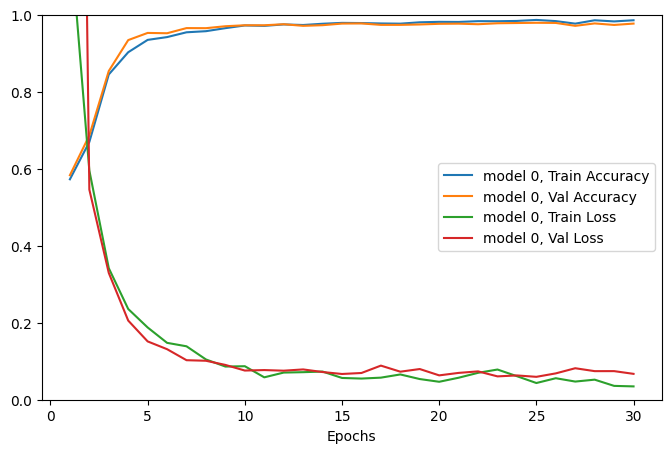

In [3]:
D.plot_train()
D.bestModelAcc()

(1, 2, 1)
Normalizing dataset from [3.06895569 1.41893612] to
[1. 1.]
Normalizing dataset from [3.07249511 1.42931556] to
[1.0011533  1.00731495]
Normalizing dataset from [3.0693023  1.43491109] to
[1.00011294 1.01125842]
Using Device:  cpu , dtype:  torch.float32
Raw data shape:  (7497, 2, 32)
Labels shape:  (7497,)
Unique labels:  [0 1 2]
Shape of test set: (1125, 2, 32)
Shape of train set: (5416, 2, 32)
Shape of validation set: (956, 2, 32)
Fraction of single class in test set:  0.31377777777777777
dtype of inputs:  torch.float32


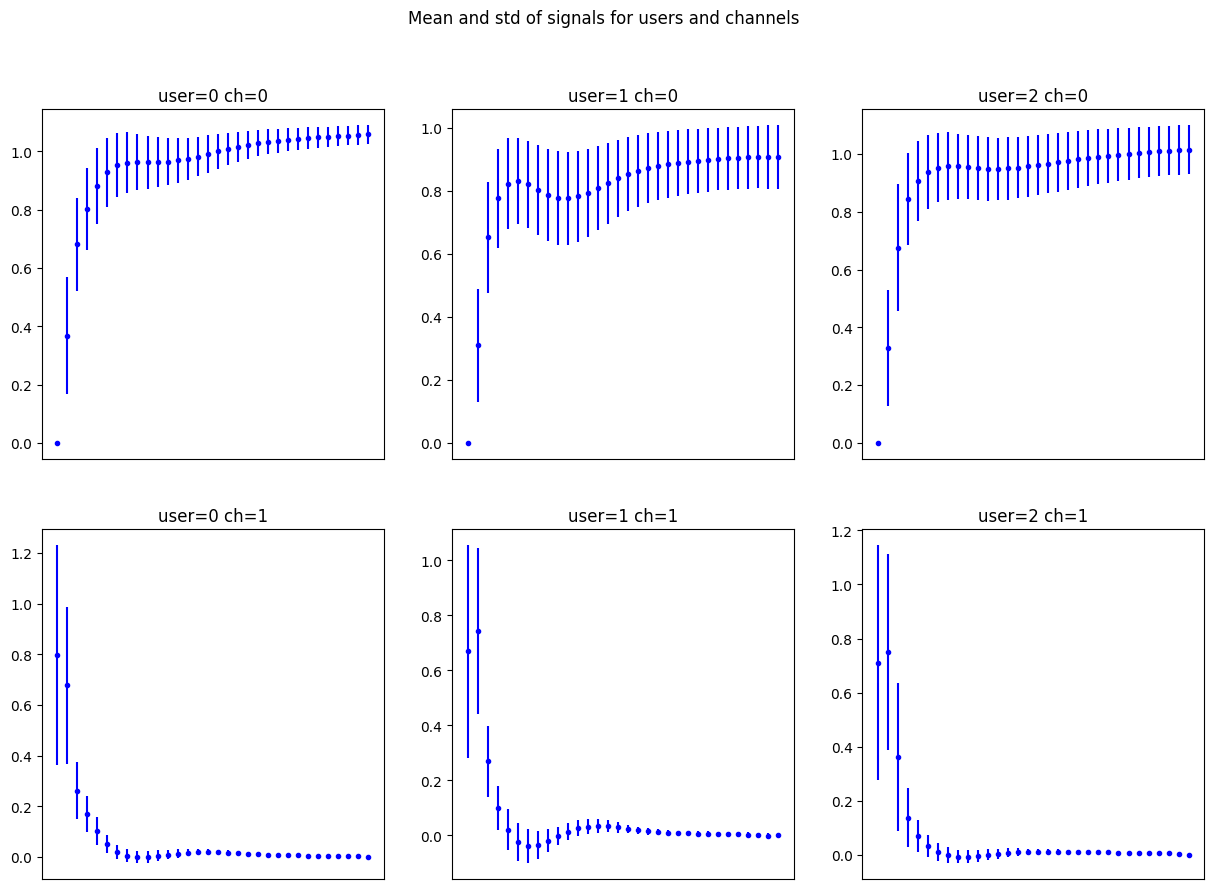

In [8]:
from core_functions import SensorSignals
from networks import CNN_Simple, CNN_Dense
# Look into transformations 
E = SensorSignals("./second_collection_triggs_rels_32.npz", triggers=True, releases=False, transforms=True) 
E.split_data()
E.norm_X()
E.setup_tensors()
E.print_shapes()
E.plot_data()

In [10]:
models = [CNN_Simple(input_ch=2, n_filters=16)]
E.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=2*256, max_epochs=50)

Epoch 1, Batch 1: loss_tr=1.222, loss_val=1.131, train=64.1%, val=65.2%
Epoch 2, Batch 1: loss_tr=0.598, loss_val=0.564, train=75.9%, val=76.4%
Epoch 3, Batch 1: loss_tr=0.400, loss_val=0.404, train=81.4%, val=83.7%
Epoch 4, Batch 1: loss_tr=0.398, loss_val=0.391, train=82.6%, val=83.2%
Epoch 5, Batch 1: loss_tr=0.372, loss_val=0.312, train=86.9%, val=86.9%
Epoch 6, Batch 1: loss_tr=0.284, loss_val=0.275, train=88.6%, val=89.2%
Epoch 7, Batch 1: loss_tr=0.291, loss_val=0.244, train=89.7%, val=89.9%
Epoch 8, Batch 1: loss_tr=0.292, loss_val=0.264, train=89.0%, val=89.2%
Epoch 9, Batch 1: loss_tr=0.256, loss_val=0.275, train=89.8%, val=89.0%
Epoch 10, Batch 1: loss_tr=0.258, loss_val=0.281, train=88.6%, val=88.1%
Epoch 11, Batch 1: loss_tr=0.260, loss_val=0.256, train=89.8%, val=88.4%
Epoch 12, Batch 1: loss_tr=0.238, loss_val=0.234, train=90.8%, val=89.7%
Epoch 13, Batch 1: loss_tr=0.277, loss_val=0.231, train=90.6%, val=90.2%
Epoch 14, Batch 1: loss_tr=0.279, loss_val=0.249, train=90.0

Accuracy of test set of best model (idx=0): 90.2%


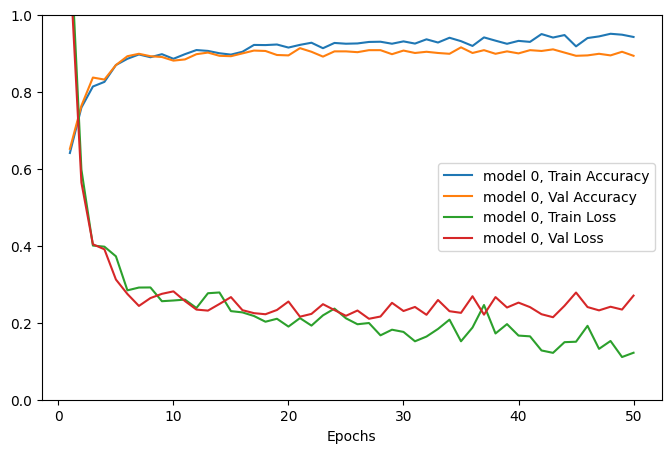

In [11]:
E.plot_train()
E.bestModelAcc()

In [ ]:
# Longer intervals of time
from core_functions import SensorSignals
from networks import CNN_Simple, CNN_Dense, CNN_64
F = SensorSignals("./second_collection_triggs_rels_64.npz")
F.split_data()
F.norm_X()
F.setup_tensors()
F.print_shapes()

In [ ]:
models = [CNN_64(input_ch=1, n_filters=8)]
F.train_multiple_models(models, learning_rate=1e-2, weight_decay=1e-3, batch_size=256, max_epochs=100)

In [ ]:
F.plot_train()
F.bestModelAcc()